In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from itertools import combinations 

C:\Users\Derrick\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [34]:
data = os.path.join('datasets', 'gdp_loans_monthly.csv')

df = pd.read_csv(data, parse_dates=[0], index_col=0, squeeze=True)
#df = df['real_gdp']

df.head()

,real_gdp,nom_gdp,loans,deposits,ipi_vol,ipi_val,pmi,gdp_yy,loans_yy,rr_rate,olfacility
date,,,,,,,,,,,
1997-01-01,NaN,NaN,1237287.0,1294703.5,NaN,NaN,NaN,NaN,NaN,10.50,NaN
1997-02-01,NaN,NaN,1264241.0,1315544.3,NaN,NaN,NaN,NaN,NaN,10.50,NaN
1997-03-01,1539321.16,636624.9867,1284591.0,1341784.8,NaN,NaN,NaN,NaN,NaN,9.90,NaN
1997-04-01,NaN,NaN,1326161.0,1341050.1,NaN,NaN,NaN,NaN,NaN,10.25,NaN
1997-05-01,NaN,NaN,1361678.0,1364119.7,NaN,NaN,NaN,NaN,NaN,16.00,NaN


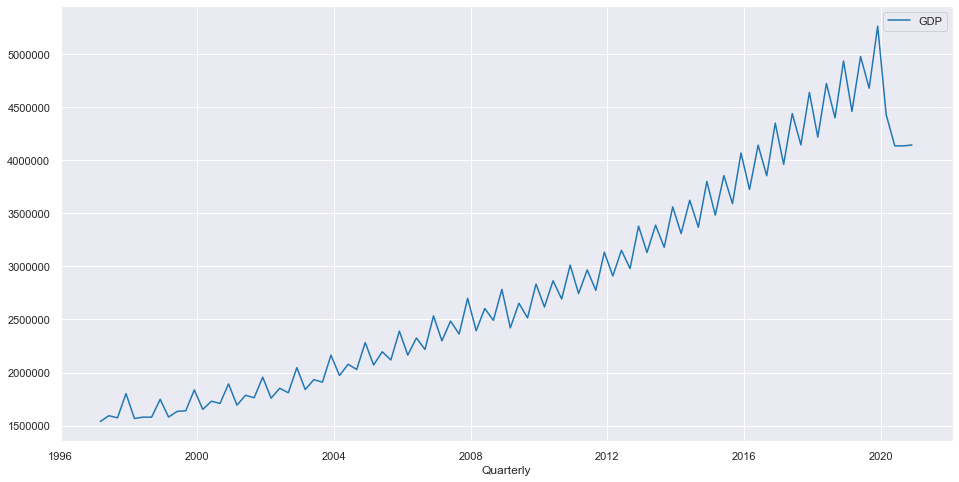

In [35]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=(16,8))

plt.plot(df.real_gdp.dropna(), color='tab:blue', label='GDP')
#plt.plot(df.gdp_gth, color='darkred', label='GDP Growth')
#plt.title('')
plt.legend()
plt.xlabel('Quarterly')

plt.show()

In [36]:
gdp_df = df.real_gdp.dropna()

def qtr_mean(series):
    means = series.groupby(series.index.month).mean()
    return series.index.map(lambda d: means.loc[d.month])

def seasonality_correct(series):
    return series - qtr_mean(series)

gdp_df = seasonality_correct(gdp_df)

gdp_yoy = gdp_df.pct_change(4).dropna()

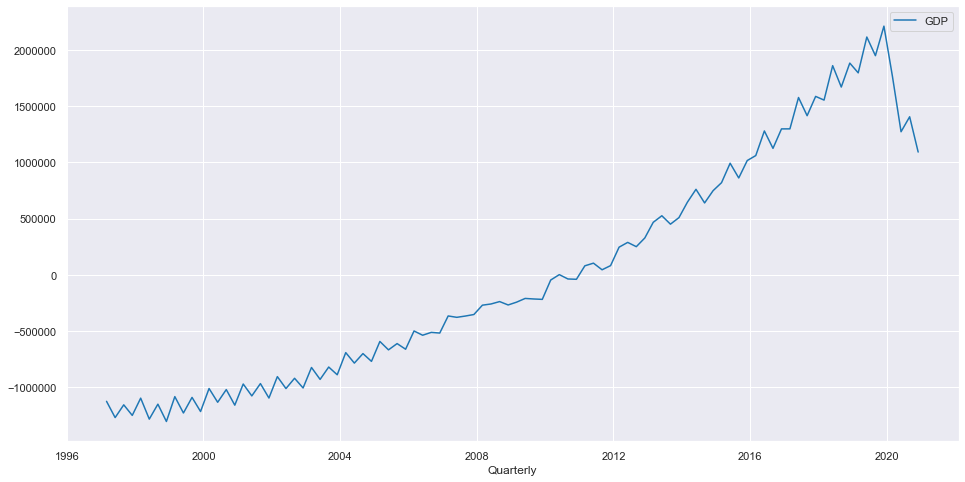

In [37]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=(16,8))

plt.plot(gdp_df, color='tab:blue', label='GDP')
plt.legend()
plt.xlabel('Quarterly')

plt.show()

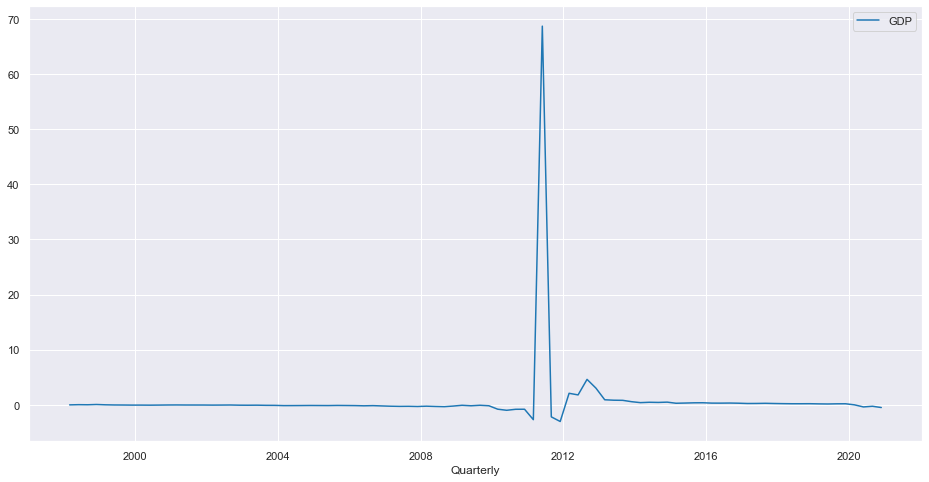

In [38]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=(16,8))

plt.plot(gdp_yoy, color='tab:blue', label='GDP')
plt.legend()
plt.xlabel('Quarterly')

plt.show()

In [39]:
gdp_yoy

date
1998-03-01   -0.025114
1998-06-01    0.010766
1998-09-01   -0.005205
1998-12-01    0.043267
1999-03-01   -0.012390
                ...   
2019-12-01    0.174514
2020-03-01   -0.017608
2020-06-01   -0.398380
2020-09-01   -0.278799
2020-12-01   -0.506374
Length: 92, dtype: float64

In [ ]:
def normalize(series):
    ave, stdev = series.mean(), series.std()
    series = (series-ave)/stdev
    return series

def annual_vol(series):
    stdevs = series.groupby(series.index.year).std()
    return series.index.map(lambda d: stdevs.loc[d.year])

def variance_correct(series):
    return series/annual_vol(series)

def qtr_mean(series):
    means = series.groupby(series.index.month).mean()
    return series.index.map(lambda d: means.loc[d.month])

def seasonality_correct(series):
    return series - qtr_mean(series)

def make_stationary(*data, plot=False, headers=True):
    stdata = []
    for d in data:
        if headers == True:
            header = d.name
        d = normalize(d)
        d = d.diff().dropna()
        d = variance_correct(d)
        d = seasonality_correct(d).dropna()
        d.name = header
        stdata.append(d)
        
    if len(stdata) == 1:
        return stdata[0]
    else:
        return stdata

def detransform(*data):
    dtdata = []
    for d in data:
        d = d #seasonality
        d = d #volatility
        d = d.groupby(level=0).diff().fillna(df).reset_index()
        d = d #normalize
    if len(dtdata) == 1:
        return dtdata[0]
    else:
        return dtdata